# Exp 41

### Comparison between dual classifier and random detector

In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp41'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [107]:
def compare(rawset, cat1, cat2,batch_size=100):
    by_category = rawset.by_category()
    
    model = tensorflow.keras.models.load_model('results/exp40/%s_%s.h5'%(cat1, cat2))
    rndmodel = tensorflow.keras.models.load_model('results/exp39/randomchk_bin.h5')

    dualset = by_category[cat1].join(by_category[cat2])

    sampler = block_sampler.BlockSamplerByFile(dualset)

    encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')

    itencoder = iter(encoder)

    sample = next(itencoder)

    prediction = model.predict(sample[0])

    rndprediction = rndmodel.predict(sample[0])

    data = pd.concat(
        [
            pd.DataFrame(sample[1]),
            pd.DataFrame(prediction),
            pd.DataFrame(rndprediction),
        ]
        ,axis=1)
    cat1 = dualset.ix_to_cat[0]
    cat2 = dualset.ix_to_cat[1]
    data.columns = [cat1, cat2, 'p_%s'%cat1, 'p_%s'%cat2, 'not_rnd', 'rnd']

    data['ok'] = data[cat1]*data['p_%s'%cat1] + data[cat2]*data['p_%s'%cat2]
    return data

In [117]:
data = compare(rawset, 'doc', 'pdf')

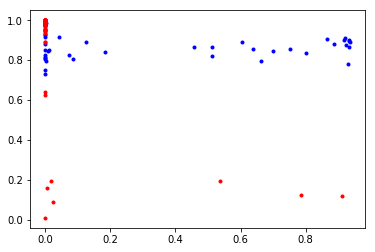

In [118]:
b = data[data.iloc[:,0]==0]
r = data[data.iloc[:,0]==1]
plt.plot(b['rnd'], b['ok'], '.b')
plt.plot(r['rnd'], r['ok'], '.r')

In [119]:
data

,doc,pdf,p_doc,p_pdf,not_rnd,rnd,ok
0,0,1,0.008737,0.991263,1.000000,0.000000e+00,0.991263
1,0,1,0.195379,0.804621,0.999486,3.294647e-04,0.804621
2,0,1,0.173145,0.826855,1.000000,0.000000e+00,0.826855
3,1,0,0.999468,0.000532,1.000000,0.000000e+00,0.999468
4,0,1,0.149181,0.850819,1.000000,3.278255e-07,0.850819
...,...,...,...,...,...,...,...
95,0,1,0.023572,0.976428,1.000000,0.000000e+00,0.976428
96,1,0,0.985986,0.014014,1.000000,0.000000e+00,0.985986
97,1,0,0.999585,0.000415,1.000000,0.000000e+00,0.999585
98,0,1,0.269525,0.730475,1.000000,0.000000e+00,0.730475
